In [117]:
import numpy as np
import json
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from shapely.geometry import Point, Polygon

from translitua import translit

In [118]:
regions_path = "data/regions/UKR_adm1.shp"
cities_path = "data/cities/cities.csv"

report_path = "data/tarilka/report.csv"

In [196]:
# list of already existing warehouses
warehouses = ["L'viv", 'Kyiv', 'Kherson']

In [193]:
df_regions = gpd.read_file(regions_path)
df_regions.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,HASC_1,CCN_1,CCA_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,240,UKR,Ukraine,1,Cherkasy,UA.CK,0,None,Oblast',Region,None,Cherkas'ka Oblast'|Cherkasskaya Oblast'|Cherkassy,"POLYGON ((32.15047 50.19769, 32.15050 50.19181..."
1,240,UKR,Ukraine,2,Chernihiv,UA.CH,0,None,Oblast',Region,None,Chernigov|Tschernigow,"POLYGON ((33.19667 52.37500, 33.20612 52.36700..."
2,240,UKR,Ukraine,3,Chernivtsi,UA.CV,0,None,Oblast',Region,None,Chernivets'ka Oblast'|Chernovitskaya Oblast'|C...,"POLYGON ((25.62595 48.67673, 25.64460 48.67159..."
3,240,UKR,Ukraine,4,Crimea,UA.KR,0,None,Autonomous Republic,Autonomous Republic,None,Crimée|Criméia|Krim|Krymskaya Respublika|Respu...,"MULTIPOLYGON (((33.79458 44.39153, 33.79291 44..."
4,240,UKR,Ukraine,5,Dnipropetrovs'k,UA.DP,0,None,Oblast',Region,None,Dnipropetrovsk|Dniepropietrovsk|Dnjepropetrowsk,"POLYGON ((34.92995 49.15574, 34.92076 49.14992..."


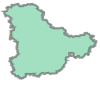

In [194]:
# there is a separate polygon shape fot Kiev city, excluded from its region
# merge them into one region and remove the city
merged_kyiv = unary_union(df_regions[df_regions['NAME_1'].isin(['Kiev', 'Kiev City'])]['geometry'])
df_regions = df_regions.drop(df_regions[df_regions['NAME_1'] == 'Kiev City'].index)
df_regions.loc[df_regions['NAME_1'] == 'Kiev', 'geometry'] = merged_kyiv

df_regions.loc[df_regions['NAME_1'] == 'Kiev', 'NAME_1'] = 'Kyiv'  # awful kacapskyi name
df_regions.loc[df_regions['NAME_1'] == 'Kirovohrad', 'NAME_1'] = 'Kropyvnytskyi'
df_regions.loc[df_regions['NAME_1'] == "Dnipropetrovs'k", 'NAME_1'] = 'Dnipro'
df_regions.loc[df_regions['NAME_1'] == 'Transcarpathia', 'NAME_1'] = 'Zakarpattia'

merged_kyiv

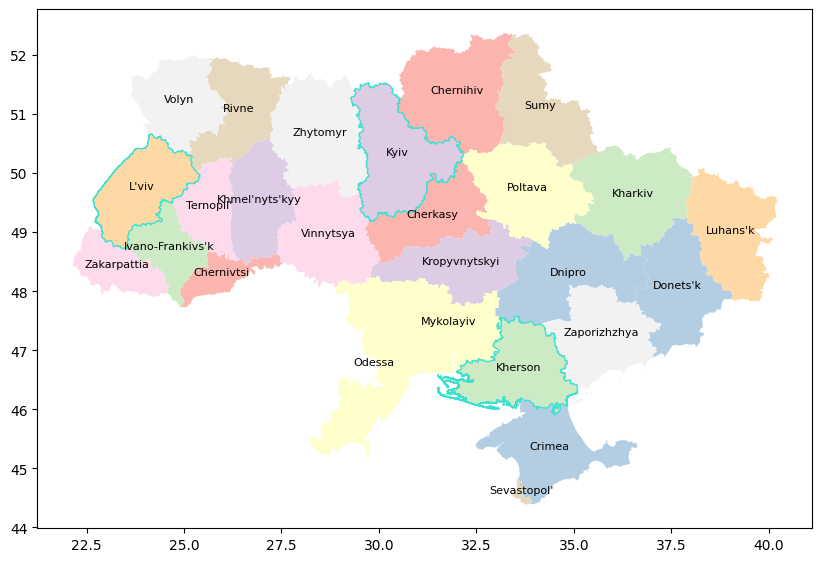

In [197]:
def plot_map(df, ax=None):
    ax = df.plot(ax=ax, cmap='Pastel1', figsize=(10, 10))

    # add regions names into the center of each shape
    df.apply(lambda x: plt.annotate(text=x['NAME_1'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=8), axis=1)

    # highlight the existing warehouses with a balder outline
    df.loc[df['NAME_1'].isin(warehouses)].plot(ax=ax, facecolor='none', edgecolor='turquoise', linewidth=1)

plot_map(df_regions)

In [145]:
df_cities = pd.read_csv(cities_path)
df_cities.head()

points = [Point(d['longitude'], d['latitude']) for d in map(json.loads, df_cities['location'].to_numpy())]

df_cities = GeoDataFrame(df_cities, geometry=points)
df_cities.head()

,objectId,muni,featureCode,countryCode,cityId,ACL,name,population,updatedAt,location,country,createdAt,adminCode,geometry
0,WrTjJLmvV5,NaN,PPL,UA,505257,NaN,Urzuf,2904,Sat Dec 14 2019 04:09:22 GMT+0200 (Eastern Eur...,"{""__type"":""GeoPoint"",""latitude"":46.91562,""long...",Ukraine,Sat Dec 14 2019 04:09:22 GMT+0200 (Eastern Eur...,5,POINT (37.09961 46.91562)
1,mWzfykE61J,NaN,PPL,UA,686818,NaN,Zuhres,19121,Sat Dec 14 2019 04:09:22 GMT+0200 (Eastern Eur...,"{""__type"":""GeoPoint"",""latitude"":48.0114,""longi...",Ukraine,Sat Dec 14 2019 04:09:22 GMT+0200 (Eastern Eur...,5,POINT (38.26444 48.01140)
2,m6UGcfy7M7,NaN,PPLA2,UA,686896,NaN,Zolochiv,22608,Sat Dec 14 2019 04:09:22 GMT+0200 (Eastern Eur...,"{""__type"":""GeoPoint"",""latitude"":49.80597,""long...",Ukraine,Sat Dec 14 2019 04:09:22 GMT+0200 (Eastern Eur...,15,POINT (24.89436 49.80597)
3,RdvzwG5b8J,NaN,PPLA2,UA,618835,NaN,Zhydachiv,0,Sat Dec 14 2019 04:09:22 GMT+0200 (Eastern Eur...,"{""__type"":""GeoPoint"",""latitude"":49.38468,""long...",Ukraine,Sat Dec 14 2019 04:09:22 GMT+0200 (Eastern Eur...,15,POINT (24.14254 49.38468)
4,EFYhjj4o0L,11153029.0,PPLA3,UA,686748,NaN,Kovyl’noye,783,Sat Dec 14 2019 04:09:22 GMT+0200 (Eastern Eur...,"{""__type"":""GeoPoint"",""latitude"":45.69028,""long...",Ukraine,Sat Dec 14 2019 04:09:22 GMT+0200 (Eastern Eur...,11,POINT (33.52775 45.69028)


In [140]:
df_report = pd.read_csv(report_path)
df_report.fillna(0, inplace=True)

df_report.head()

,Unnamed: 0,Статус,Населений пункт,Потребуючі,Що передаємо,К-сть осіб,Набір звичайний,Набір сімейний,дорослі щітки,доросла паста,шампунь,мило,жіночі прокладки,підгузки дитячі,підгузки дорослі
0,1,0,Харків,пенсіонерка,"предмети особистої гігієни, продукти харчування\n",1.0,1.0,0.0,1,1,1,1,0.0,0,0
1,2,відправлено,Харків,інвалід і батьки-пенсіонери,"предмети особистої гігієни, продукти харчування\n",3.0,1.0,0.0,3,1,1,1,1.0,0,0
2,3,відправлено,Київ,ВПО з Херсону: мама і двоє дітей,"предмети особистої гігієни, продукти харчування\n",3.0,1.0,0.0,3,1,1,1,2.0,0,0
3,4,відправлено,Запоріжжя,пенсіонерка,"предмети особистої гігієни, продукти харчування\n",1.0,1.0,0.0,1,1,1,1,1.0,0,0
4,5,відправлено,Костянтинівка Донецька обл,"пенсіонерка, мама-одиначка і дитина","предмети особистої гігієни, продукти харчування\n",3.0,1.0,0.0,3,1,1,1,1.0,0,0


In [174]:
transliterated = [translit(name) for name in df_report['Населений пункт'].to_numpy()]
df_report.insert(3, 'city', transliterated)

df_report.head()

ValueError: cannot insert city, already exists

In [176]:
set(df_report['city'].to_numpy())

{'0',
 'Apostolove Dnipropetrovska obl',
 'Avanhard Odeska obl',
 'Balakliia',
 'Balta Odeska obl',
 'Banyliv-Pidhirnyk Chernivetska obl',
 'Berdychiv Zhytomyrska obl',
 'Berehovo',
 'Berehovo Zakarpatska obl',
 'Berezanka Mykolaivska obl',
 'Bezliudivka Kharkivska obl',
 'Bila Tserkva',
 'Bilhorod Dnistrovskyi',
 'Bilhorod-Dnistrovskyi Odeska obl',
 'Blyzniuky Kharkivska obl.',
 'Blyzniuky, Kharkivska obl',
 'Bobrynets Kirovohradska obl',
 'Bohodukhiv',
 'Bohodukhiv Kharkivska obl',
 'Bolekhiv',
 'Boryspil',
 'Boryspil Kyivska obl',
 'Brovarky Poltavska obl',
 'Brovary',
 'Brusyliv Zhytomyrska obl',
 'Bucha Kyivska obl',
 'Buryn Sumska obl',
 'Buzhanka Cherkaska obl',
 'Bylbasivka Donetska obl',
 'Chabany Kyivska obl',
 'Chechelnyk Vinnytska obl',
 'Cherkasy',
 'Chernihiv',
 'Chernivtsi',
 'Chernukhy Poltavska obl',
 'Chervonohrad Lvivska obl',
 'Chervonohryhorivka Nikopolskyi r-n Dnipropetrovska obl',
 'Chop Zakarpatska obl',
 'Chornomorsk',
 'Chuhuiv',
 'Chuhuiv Kharkivska obl',
 'D

In [181]:
obl_to_cities = {
    'Cherkaska': 'Cherkasy',
    'Chernihivska': 'Chernihiv',
    'Chernivetska': 'Chernivtsi',
    'Dnipropetrovska': 'Dnipro',
    'Donetska': 'Donetsk',
    'Ivano-Frankivska': 'Ivano-Frankivsk',
    'Kharkivska': 'Kharkiv',
    'Khersonska': 'Kherson',
    'Khmelnytska': 'Khmelnytskyi',
    'Kyivska': 'Kyiv',
    'Kirovohradska': 'Kropyvnytskyi',
    'Lvivska': 'Lviv',
    'Luhanska': 'Luhansk',
    'Mykolaivska': 'Mykolayiv',
    'Odeska': 'Odessa',
    'Poltavska': 'Poltava',
    'Rivnenska': 'Rivne',
    'Sumska': 'Sumy',
    'Ternopilska': 'Ternopil',
    'Zakarpatska': 'Uzhgorod',
    'Vinnytska': 'Vinnytsia',
    'Volynska': 'Lutsk',
    'Zaporizka': 'Zaporizhia',
    'Zhytomyrska': 'Zhytomyr',
}

In [183]:
destinations = df_report['city'].to_numpy()
capacity = df_report['К-сть осіб'].to_numpy()

found = 0
found_dict = {}
for idx, city in enumerate(destinations):
    for subname in city.split(' '):
        if not df_cities[df_cities['name'] == subname].empty:
            found += 1
            if subname in found_dict:
                found_dict[subname] += int(capacity[idx])
            else:
                found_dict[subname] = int(capacity[idx])
            continue
        if subname in obl_to_cities:
            found += 1
            if int(capacity[idx]) in found_dict:
                found_dict[obl_to_cities[subname]] += int(capacity[idx])
            else:
                found_dict[obl_to_cities[subname]] = int(capacity[idx])
            continue

print(f'Cities found: {found}\nCities not found: {len(destinations) - found}')


Cities found: 707
Cities not found: 63


In [184]:
df_destinations = df_cities[df_cities['name'].isin(found_dict.keys())][['name', 'population', 'geometry']]
df_destinations['capacity'] = list(map(found_dict.get, df_destinations['name'].to_numpy()))
df_destinations.head()

,name,population,geometry,capacity
2,Zolochiv,22608,POINT (24.89436 49.80597),4
5,Druzhkivka,62315,POINT (37.55259 48.63013),25
11,Lebedyn,27695,POINT (34.48490 50.58518),4
18,Zolochiv,11160,POINT (35.98179 50.27985),4
25,Zhytomyr,282192,POINT (28.67669 50.26487),6


<AxesSubplot: >

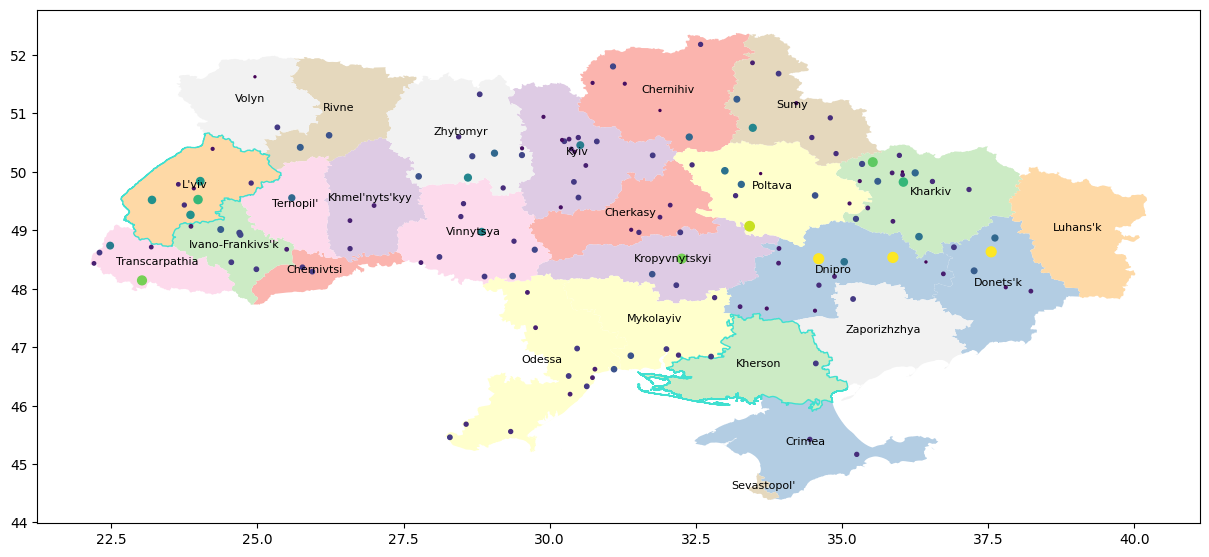

In [186]:
fig, ax = plt.subplots(figsize=(15, 15))

plot_map(df_regions, ax)

df_destinations.plot(ax=ax, marker='o', markersize=2 * df_destinations['capacity'], column='capacity')